In [1]:
import warnings
warnings.simplefilter('ignore')

from sklearn import svm
import pickle
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.externals import joblib


from stop_words import get_stop_words
pd.options.mode.chained_assignment = None
import string

import time
import re
import os
import json
import subprocess
import csv
import gzip
from datetime import datetime
import itertools

import matplotlib.pyplot as plt


# Tokenizers
from nltk.tokenize.casual import TweetTokenizer

# Imbalanced classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, ADASYN

import eli5

# Define Classifier Evaluation Functions
These functions will be used later to test differently balanced tweetsets in order to arrive at the tweetset balance that best supports effective model training (as per F1, Precision, and Recall scores).

In [2]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def show_conf_matrices(y_test, y_predictions):
    ## from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    ## compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predictions)
    np.set_printoptions(precision=2)

    ## make class labels
    y_labels = []
    for item in y_test:
        if item not in y_labels:
            y_labels.append(item)
        else:
            continue
    
    ## plot non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix,classes=y_labels,
                          title='Confusion matrix, without normalization')

    ## plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=y_labels, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

def eval_classifier(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)

    print(classification_report(y_test, y_pred) +  
          "\nCohen's kappa: " + str(cohen_kappa_score(y_test,y_pred)))
    
    show_conf_matrices(y_test, y_pred)  

# Set Notebook Parameters
Here we set variables necessary for pre-processing data for classifier training.

In [3]:
# tokenizer = RegexpTokenizer(r'\w+')
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) # which tokenizer to use

stop_words_en = get_stop_words('en') # English stoplist
stop_words_sp = get_stop_words('spanish') # Spanish stoplist

stop_words_2 = []

for word in stop_words_en:
    stop_words_2.append(word)
for word in stop_words_sp:
    stop_words_2.append(word)


In [4]:
def tokenize_func(doc):

    ## remove URLs
    doc = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', doc, flags=re.MULTILINE)
    
    ## tokenize
    tokens = tokenizer.tokenize(doc)

    ## remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    nopunct_tokens = [w.translate(table) for w in tokens]
    for tok in nopunct_tokens:
        if 'httptco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])
        elif 'httpstco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])

    ## keep words length 3 or more
    long_tokens = [token for token in nopunct_tokens if len(token) > 2]

    ## remove remaining tokens that are not alphabetic
    alpha_tokens = [word for word in long_tokens if word.isalpha()]

    ## remove stop words from tokens
    stopped_tokens = [i for i in alpha_tokens if not i in stop_words_2]
        
    return stopped_tokens

def replace_urls(text):
    text_clean = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', text, flags=re.MULTILINE)
    return text_clean

# Get Data

Russell's raw data is not publicly available at this time (we received Russell's raw data via private email). As such, though we include all code we used to prepare the data to build and test our supervised model, we have commented out those lines which require raw datasets. 
    
The processed data that we used to train and test the model can be found at:

    '../../../../data/russell/russell_processed_0.9.csv.gz'

In [5]:
# data_file = 'RAWDATA_russell'
# tweets = pd.read_csv(data_file, dtype=str, compression='gzip')

# Process Data

In [6]:
def process_data(tweets):
    
    ## rename columns
    tweets['new_topic_1'] = tweets['new_topic_1'].astype(str)
    tweets.rename(index=str, columns={'Topic Code': 'topic_code'})

    col_names = list(tweets.columns.values)

    ## uncomment to display tweets dataframe dimensions
    # tweets.shape
    
    ## remove retweets in training set
    tweets['original'] = np.where(tweets.text.str.startswith('RT'), 0, 1)

    original_tweets = tweets[tweets['original'] == 1]

    ## recast datatypes for relevant columns
    original_tweets['topic_code'] = original_tweets['Topic Code'].apply(str)
    original_tweets['datetime'] = pd.to_datetime(original_tweets['Date'])
    original_tweets['date'] = original_tweets['datetime'].dt.date
    original_tweets['year'] = original_tweets['datetime'].dt.year
    original_tweets['month'] = original_tweets['datetime'].dt.month
    
    ## create new column with tweet text sans urls
    original_tweets['text_no_urls'] = original_tweets['text'].apply(replace_urls)
    
    ## uncomment to display column names
    # original_tweets.columns.values
    
    original_tweets = original_tweets.drop(['Unnamed: 0', 'KEYID', 'State', 'Name', 'text', 'Date', 
                     'Unique_ID', 'Topic Code', 'Policy Content', 'Oversight', 
                     'Partisanship', 'Elections', 'CreditClaim', 'Constituent Meeting', 
                     'Constituent Issues/Details', 'Sports', 'Holidays/Anniversaries', 
                     'Press Release', 'Photos or Videos', 'Media Appearance', 'Media/Report', 
                     'Inst. Action', 'CODA', 'Speech', 'Link#', 'Boston', 'Link', 'DirectCommCon', 
                     'DirectCommElite', 'Other', 'POSITIVE', 'NEGATIVE', 'Negative', 'Positive', 
                     'Nuetral', 'Sentiment', 'RT', 'Retweets', 'Hashtags', 'Constituent', 
                     'Unique_ID_two', 'text_two', 'unique_id', 'unique_id_two', 'new_topic_2', 'original', 
                     'topic_code', 'datetime', 'date', 'year', 'month'], axis=1)
    
    return original_tweets

In [7]:
# original_tweets = process_data(tweets)

## Balance Tweetset
Non-policy tweets are disproportionately represented in the dataset in relation to policy tweets. As such, this code functions to balance the tweetset in such way that our classifier may more effectively learn classification patterns

In [8]:
def balance_tweetset(original_tweets):
    
    ## this code section tests different fractions of non-policy tweets to keep in increments of 10%.
    ## need to take this df of policy tweets, and merge back (or rather concatenate back) with a random 
    ## selection of those Tweets classified as '0'

    fractions = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
    fractions_dfs = {}

    for f in fractions:
        policy_filter = original_tweets.copy()
        policy_filter = policy_filter.drop(policy_filter.query('new_topic_1 == "0"' ).sample(frac=f).index)
        policy_0 = policy_filter[policy_filter.new_topic_1=='0']
        policy_filter['text_tokenized'] = [tokenize_func(n) for n in policy_filter.text]
            
        fractions_dfs[f] = policy_filter
        
    return fractions_dfs

In [9]:
# fractions_dfs = balance_tweetset(original_tweets)

In [13]:
## output best performing balance to csv, uncomment to use
# fractions_dfs[0.9].to_csv('../../../../data/russell/russell_processed_0.9.csv.gz', 
#                           compression='gzip', index=False)

## Make Training and Test Sets
Here each tweet is its own document. We include code to test all tweetset balances. We provide our final processed Russell dataset, which inludes 90% non-policy tweets. As such, if attempting to reproduce our work, the code that follows will display results for this tweetset balance only.

In [18]:
## load data here if attempting to reproduce the below code, this is Russell's processed data
data_file = '../../../../data/russell/russell_processed_0.9.csv.gz'
tweets = pd.read_csv(data_file, dtype=str, compression='gzip')
fractions_dfs = {0.9:tweets}

In [19]:
def make_training_docs(df):
    
    x = np.array(df.text_no_urls)
    y = np.asarray(df['new_topic_1'])

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
    
    return x_train, x_test, y_train, y_test

In [20]:
def make_dict_balanced_training_docs(fractions_dfs):

    ## creating a dict of all of the different fractions of non-policy tweets to include in train and test sets
    train_test = {}

    for k,v in fractions_dfs.items():
        x_train, x_test, y_train, y_test = make_training_docs(v)
        train_test[k] = x_train, x_test, y_train, y_test
        # print("Using " + str(len(x_train)) + " original tweets to TRAIN the model. This excludes Retweets.")
        # print("Using " + str(len(x_test)) + " original tweets to TEST the model. This excludes Retweets.")
    
    return train_test

In [21]:
train_test = make_dict_balanced_training_docs(fractions_dfs)

# CountVectorizer

In [13]:
## Turn train and test sets into vectors using CountVectorizer (Bag of Words)
vec = CountVectorizer(tokenizer=tokenize_func)

# Test Classifiers With Different Tweetsets

When attempting to run a logistic regression classifier on the child class (original) topic labeling system Dr. Russell used (i.e. 1001 for topic 10, subtopic 1), received the following error: "The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3." This could also be what affected initial Naive Bayes performance. As such, new models of each type were created to predict only the PARENT class in Dr. Russell's data (i.e. 10 for topic 10). This parent class was added as an additional column to Dr. Russell's data.

The overall best performing model predicting parent classes (F1 = 0.791, Cohen's Kappa with human labels = 0.769) was a logistic regression including 90% of non-policy tweets (accessed by calling fractions_dfs[0.9]).

## Dummy Classifier

WITH 10.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.31      0.31      0.31      1812
          1       0.09      0.08      0.09       445
         10       0.03      0.03      0.03        79
         12       0.06      0.05      0.06       370
         13       0.00      0.00      0.00        50
         14       0.00      0.00      0.00        34
         15       0.02      0.02      0.02       196
         16       0.05      0.06      0.06       357
         17       0.00      0.00      0.00        36
         18       0.00      0.00      0.00        17
         19       0.04      0.04      0.04       225
          2       0.03      0.03      0.03       276
         20       0.09      0.09      0.09       344
         21       0.00      0.00      0.00        73
          3       0.09      0.10      0.10       559
          4       0.02      0.02      0.02       120
          5       0.02      0.02      0.02       130
          6       0.03      0.03      0.03   

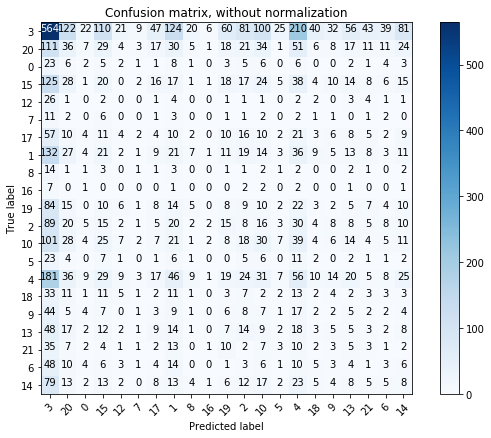

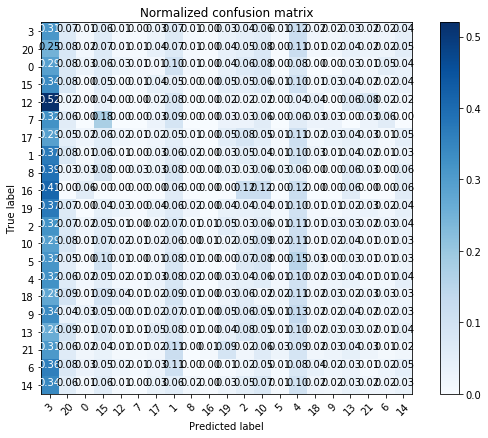

WITH 20.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.28      0.29      0.28      1567
          1       0.09      0.09      0.09       417
         10       0.05      0.03      0.04        87
         12       0.07      0.07      0.07       381
         13       0.03      0.03      0.03        66
         14       0.03      0.03      0.03        29
         15       0.03      0.03      0.03       178
         16       0.07      0.07      0.07       396
         17       0.00      0.00      0.00        47
         18       0.00      0.00      0.00        14
         19       0.03      0.03      0.03       216
          2       0.04      0.04      0.04       270
         20       0.08      0.08      0.08       339
         21       0.01      0.01      0.01        73
          3       0.12      0.11      0.12       628
          4       0.01      0.01      0.01       108
          5       0.01      0.01      0.01       116
          6       0.00      0.00      0.00   

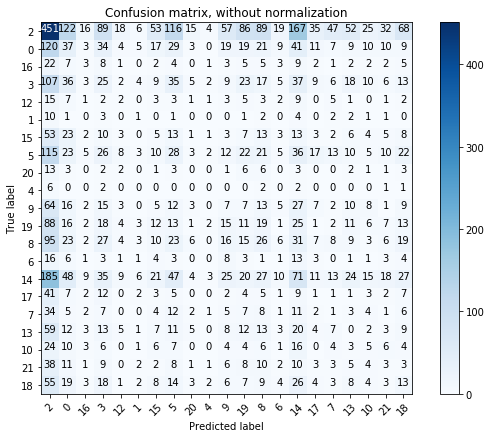

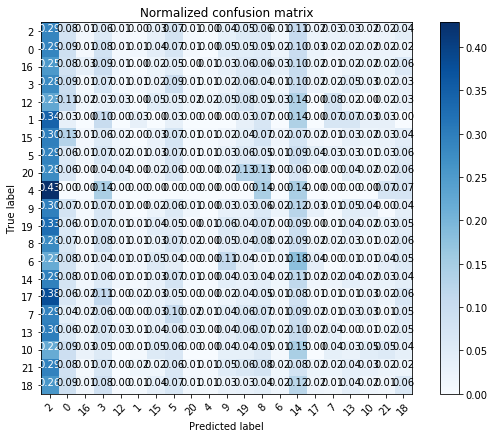

WITH 30.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.27      0.26      0.27      1475
          1       0.05      0.06      0.05       405
         10       0.02      0.02      0.02        84
         12       0.07      0.09      0.08       329
         13       0.00      0.00      0.00        70
         14       0.00      0.00      0.00        42
         15       0.03      0.04      0.04       156
         16       0.07      0.06      0.06       375
         17       0.00      0.00      0.00        52
         18       0.00      0.00      0.00        17
         19       0.06      0.05      0.05       213
          2       0.03      0.03      0.03       253
         20       0.06      0.06      0.06       318
         21       0.00      0.00      0.00        86
          3       0.11      0.10      0.10       602
          4       0.03      0.04      0.04       108
          5       0.01      0.01      0.01       120
          6       0.05      0.05      0.05   

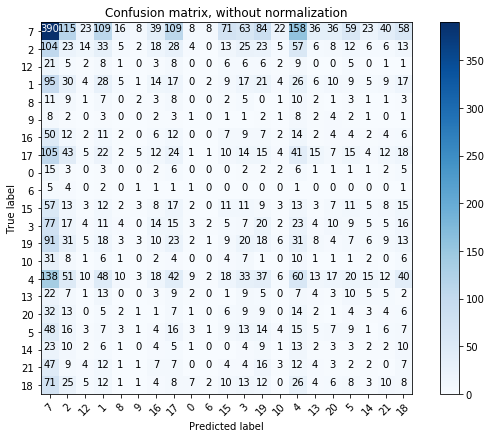

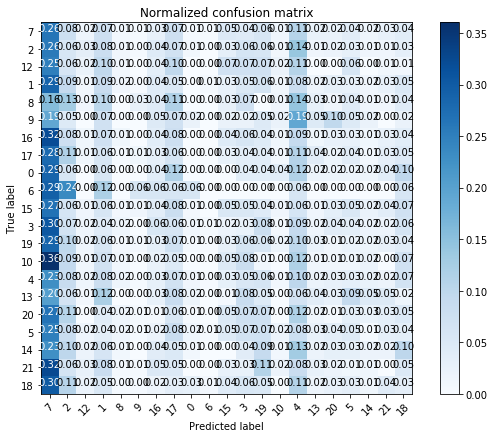

WITH 40.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.23      0.24      0.24      1183
          1       0.08      0.08      0.08       428
         10       0.01      0.01      0.01        74
         12       0.08      0.08      0.08       377
         13       0.02      0.02      0.02        63
         14       0.00      0.00      0.00        35
         15       0.01      0.01      0.01       191
         16       0.08      0.08      0.08       372
         17       0.00      0.00      0.00        50
         18       0.00      0.00      0.00        12
         19       0.06      0.06      0.06       224
          2       0.08      0.09      0.08       258
         20       0.09      0.08      0.08       342
         21       0.00      0.00      0.00        69
          3       0.11      0.12      0.12       615
          4       0.04      0.04      0.04       108
          5       0.01      0.01      0.01       130
          6       0.03      0.03      0.03   

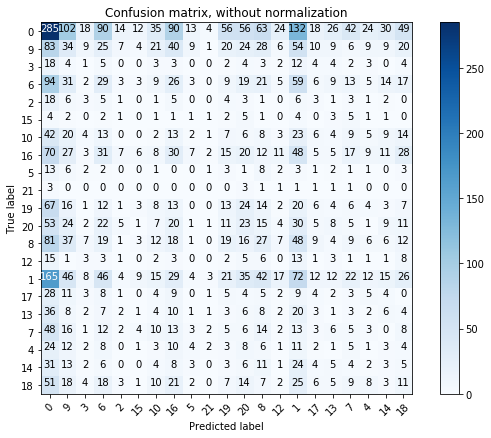

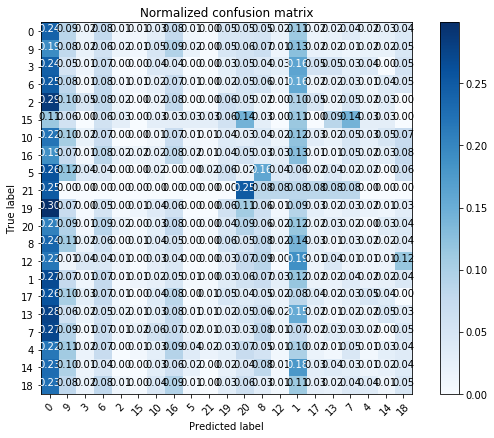

WITH 50.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.21      0.21      0.21       997
          1       0.09      0.09      0.09       437
         10       0.00      0.00      0.00        86
         12       0.05      0.05      0.05       376
         13       0.02      0.02      0.02        52
         14       0.03      0.03      0.03        31
         15       0.05      0.05      0.05       163
         16       0.06      0.06      0.06       379
         17       0.04      0.04      0.04        53
         18       0.00      0.00      0.00        16
         19       0.05      0.05      0.05       210
          2       0.05      0.05      0.05       260
         20       0.07      0.07      0.07       333
         21       0.00      0.00      0.00        63
          3       0.13      0.14      0.13       613
          4       0.04      0.05      0.04       109
          5       0.02      0.01      0.02       140
          6       0.04      0.04      0.04   

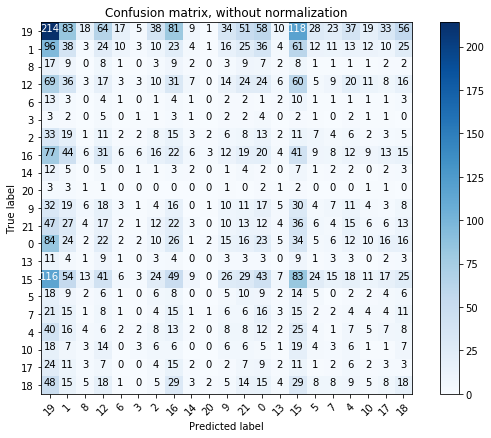

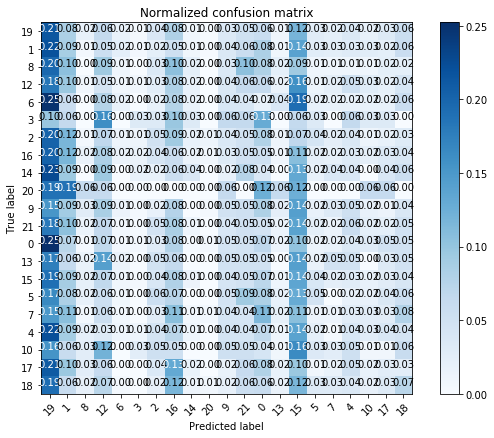

WITH 60.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.17      0.18      0.18       793
          1       0.08      0.09      0.09       414
         10       0.00      0.00      0.00        80
         12       0.08      0.07      0.08       342
         13       0.01      0.02      0.01        66
         14       0.00      0.00      0.00        47
         15       0.03      0.03      0.03       156
         16       0.09      0.08      0.08       377
         17       0.00      0.00      0.00        51
         18       0.00      0.00      0.00        21
         19       0.06      0.06      0.06       213
          2       0.05      0.05      0.05       288
         20       0.09      0.09      0.09       352
         21       0.01      0.01      0.01        72
          3       0.12      0.12      0.12       593
          4       0.02      0.02      0.02       131
          5       0.02      0.02      0.02       128
          6       0.03      0.03      0.03   

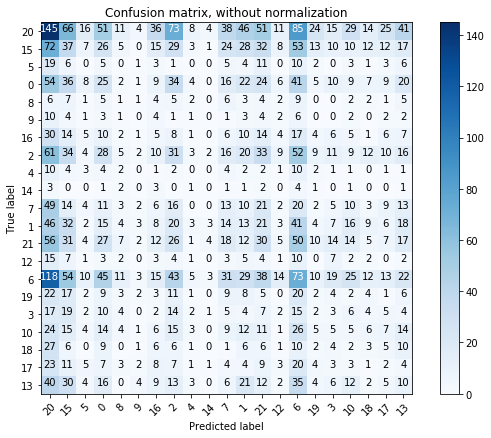

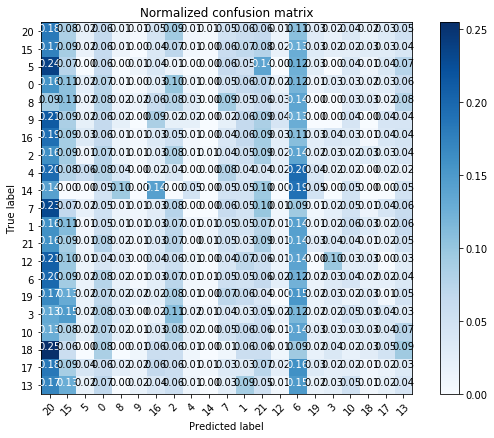

WITH 70.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.14      0.14      0.14       592
          1       0.08      0.09      0.09       416
         10       0.00      0.00      0.00        74
         12       0.09      0.09      0.09       352
         13       0.00      0.00      0.00        63
         14       0.00      0.00      0.00        41
         15       0.04      0.05      0.04       163
         16       0.09      0.09      0.09       394
         17       0.00      0.00      0.00        50
         18       0.00      0.00      0.00        15
         19       0.04      0.04      0.04       211
          2       0.05      0.04      0.04       291
         20       0.07      0.07      0.07       338
         21       0.00      0.00      0.00        55
          3       0.13      0.13      0.13       608
          4       0.03      0.03      0.03       109
          5       0.03      0.03      0.03       130
          6       0.05      0.05      0.05   

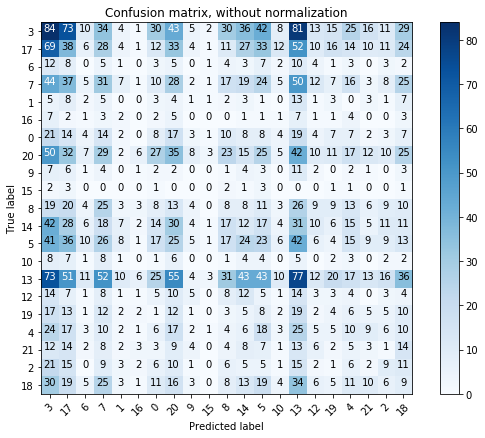

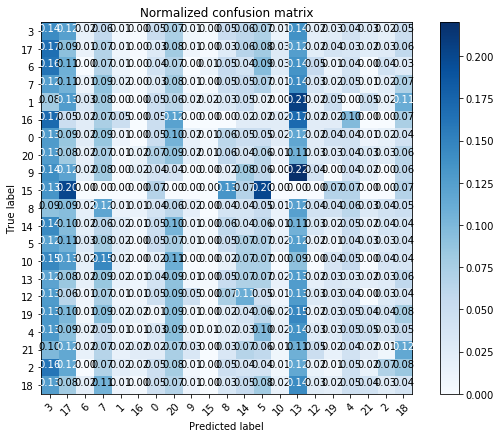

WITH 80.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.09      0.09      0.09       431
          1       0.10      0.10      0.10       420
         10       0.00      0.00      0.00        94
         12       0.07      0.06      0.06       375
         13       0.01      0.02      0.02        61
         14       0.00      0.00      0.00        32
         15       0.03      0.04      0.04       166
         16       0.07      0.08      0.08       382
         17       0.00      0.00      0.00        52
         18       0.00      0.00      0.00        18
         19       0.04      0.04      0.04       200
          2       0.06      0.06      0.06       244
         20       0.09      0.08      0.09       320
         21       0.01      0.01      0.01        74
          3       0.12      0.12      0.12       583
          4       0.05      0.06      0.06       105
          5       0.01      0.01      0.01       122
          6       0.05      0.04      0.05   

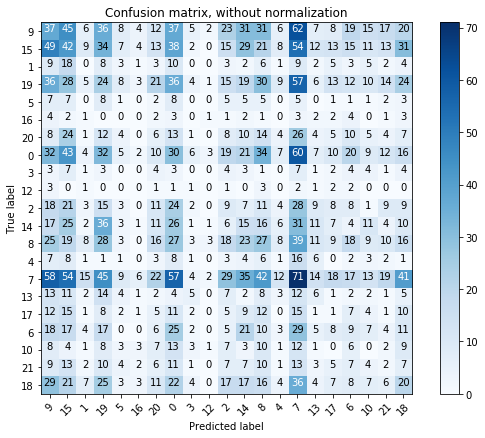

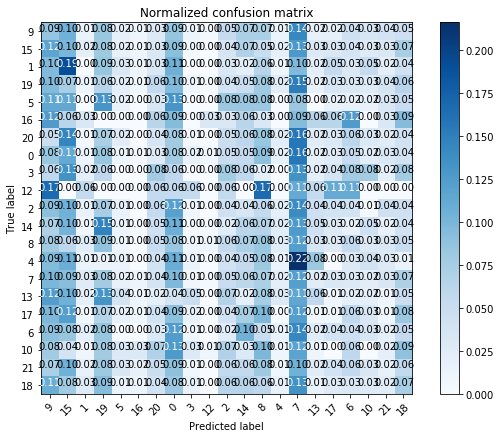

WITH 90.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


             precision    recall  f1-score   support

          0       0.06      0.06      0.06       186
          1       0.07      0.07      0.07       456
         10       0.01      0.01      0.01        96
         12       0.07      0.07      0.07       365
         13       0.00      0.00      0.00        74
         14       0.00      0.00      0.00        20
         15       0.06      0.07      0.06       160
         16       0.09      0.10      0.09       359
         17       0.00      0.00      0.00        54
         18       0.00      0.00      0.00        11
         19       0.03      0.03      0.03       215
          2       0.07      0.08      0.07       246
         20       0.09      0.09      0.09       343
         21       0.05      0.06      0.05        68
          3       0.14      0.13      0.14       598
          4       0.06      0.05      0.05       127
          5       0.03      0.03      0.03       120
          6       0.04      0.04      0.04   

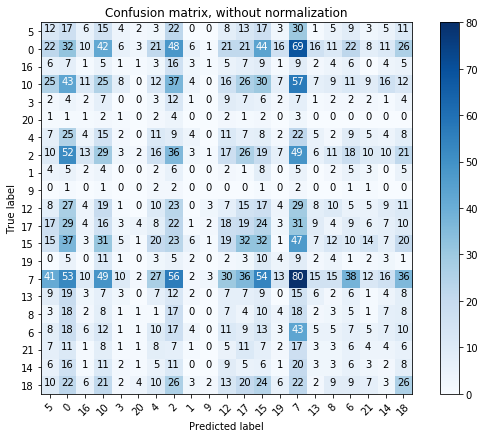

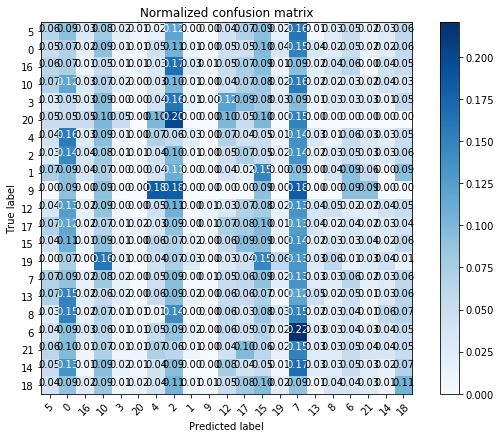

CPU times: user 2min 40s, sys: 7.55 s, total: 2min 47s
Wall time: 2min 29s


In [55]:
%%time
dmy = DummyClassifier(strategy='stratified')

pipeline = make_pipeline(vec,
                        dmy)

for k,v in train_test.items():
    print("WITH " + str(k*100) + "% 0S REMOVED")
    pipeline.fit(v[0], v[2])
    ## uncomment to save model
    # joblib.dump(pipeline, '../../../../models/best/d/dmy_' + str(k) + '.pkl')
    eval_classifier(pipeline, v[1], v[3])

## Naive Bayes Classifier

WITH 10.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.70      0.87      0.78      1812
          1       0.55      0.80      0.65       445
         10       0.84      0.20      0.33        79
         12       0.80      0.80      0.80       370
         13       1.00      0.20      0.33        50
         14       1.00      0.18      0.30        34
         15       0.67      0.49      0.56       196
         16       0.64      0.62      0.63       357
         17       0.60      0.08      0.15        36
         18       0.00      0.00      0.00        17
         19       0.76      0.50      0.60       225
          2       0.82      0.72      0.77       276
         20       0.66      0.63      0.64       344
         21       0.46      0.08      0.14        73
          3       0.74      0.87      0.80       559
          4       0.82      0.38      0.52       120
          5       0.68      0.23      0.34       130
          6       0.89      0.60      0.72   

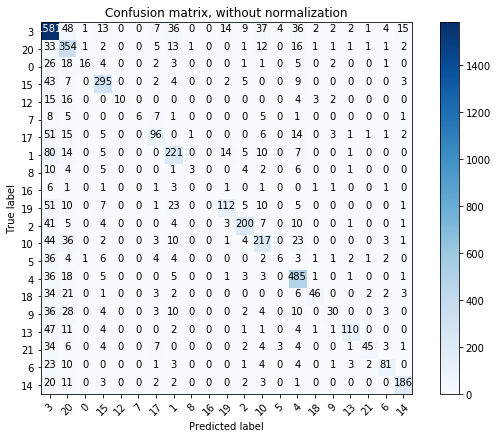

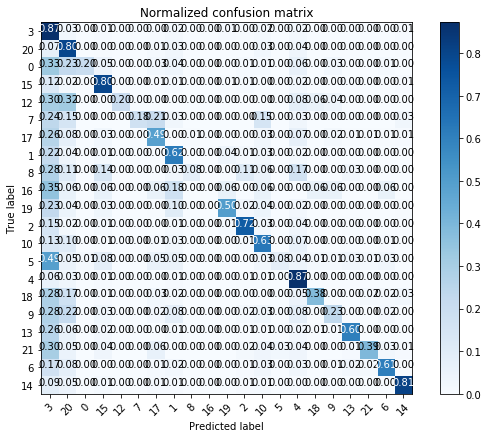

WITH 20.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.68      0.84      0.75      1567
          1       0.55      0.86      0.67       417
         10       0.95      0.23      0.37        87
         12       0.79      0.79      0.79       381
         13       0.94      0.23      0.37        66
         14       0.82      0.31      0.45        29
         15       0.70      0.47      0.56       178
         16       0.70      0.62      0.66       396
         17       1.00      0.17      0.29        47
         18       0.00      0.00      0.00        14
         19       0.72      0.50      0.59       216
          2       0.80      0.75      0.78       270
         20       0.67      0.62      0.65       339
         21       0.69      0.15      0.25        73
          3       0.75      0.88      0.81       628
          4       0.80      0.48      0.60       108
          5       0.67      0.31      0.42       116
          6       0.90      0.66      0.76   

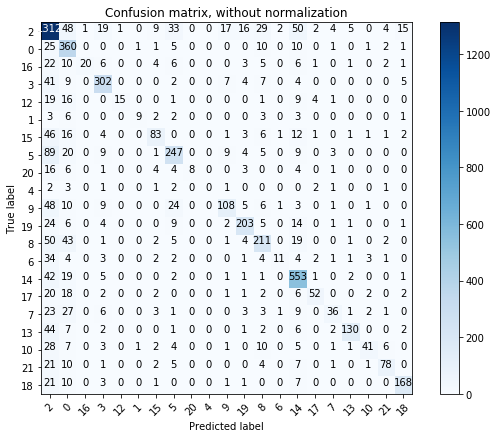

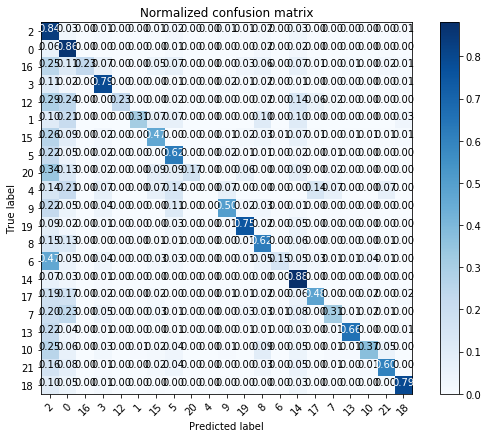

WITH 30.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.68      0.85      0.75      1475
          1       0.52      0.81      0.63       405
         10       0.84      0.25      0.39        84
         12       0.76      0.81      0.79       329
         13       0.95      0.26      0.40        70
         14       1.00      0.10      0.17        42
         15       0.66      0.45      0.53       156
         16       0.62      0.60      0.61       375
         17       0.80      0.08      0.14        52
         18       0.00      0.00      0.00        17
         19       0.77      0.52      0.62       213
          2       0.82      0.68      0.75       253
         20       0.65      0.63      0.64       318
         21       0.72      0.15      0.25        86
          3       0.73      0.89      0.80       602
          4       0.83      0.49      0.62       108
          5       0.60      0.26      0.36       120
          6       0.89      0.62      0.73   

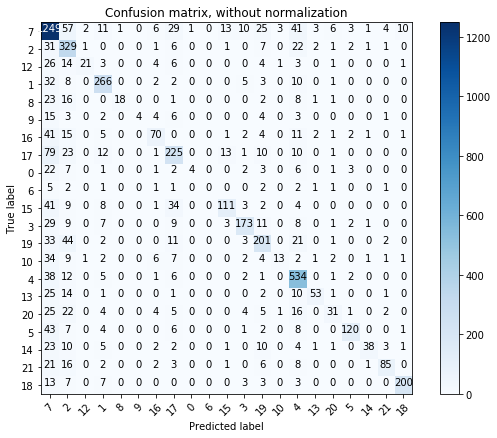

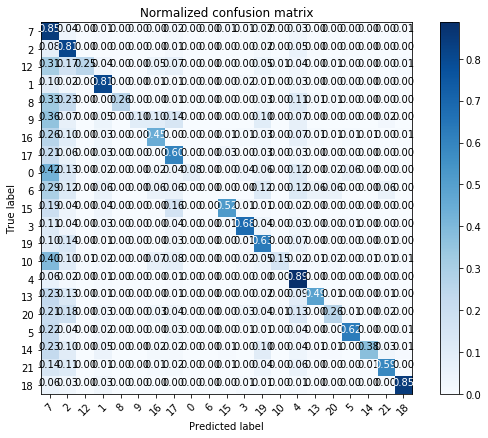

WITH 40.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.67      0.83      0.74      1183
          1       0.57      0.83      0.67       428
         10       0.90      0.26      0.40        74
         12       0.79      0.83      0.81       377
         13       0.89      0.25      0.40        63
         14       0.88      0.20      0.33        35
         15       0.73      0.49      0.58       191
         16       0.65      0.63      0.64       372
         17       1.00      0.16      0.28        50
         18       0.00      0.00      0.00        12
         19       0.77      0.59      0.67       224
          2       0.78      0.71      0.74       258
         20       0.70      0.65      0.67       342
         21       0.85      0.16      0.27        69
          3       0.71      0.89      0.79       615
          4       0.85      0.52      0.64       108
          5       0.68      0.25      0.36       130
          6       0.87      0.68      0.76   

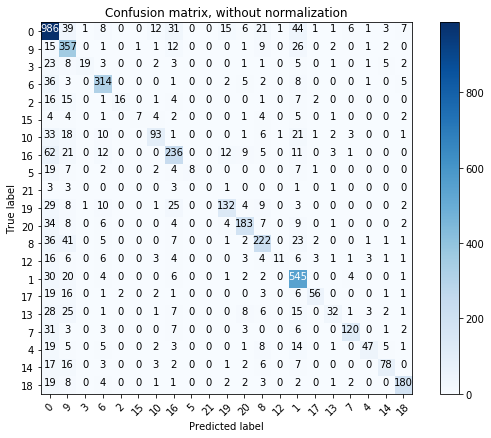

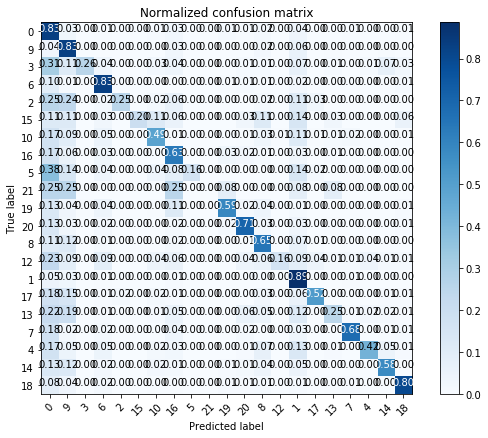

WITH 50.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.65      0.81      0.73       997
          1       0.55      0.82      0.66       437
         10       0.88      0.33      0.47        86
         12       0.79      0.82      0.81       376
         13       0.93      0.27      0.42        52
         14       0.80      0.13      0.22        31
         15       0.69      0.53      0.60       163
         16       0.66      0.70      0.68       379
         17       0.86      0.11      0.20        53
         18       0.00      0.00      0.00        16
         19       0.83      0.57      0.67       210
          2       0.74      0.75      0.75       260
         20       0.63      0.61      0.62       333
         21       0.78      0.22      0.35        63
          3       0.73      0.90      0.80       613
          4       0.85      0.50      0.63       109
          5       0.77      0.33      0.46       140
          6       0.92      0.67      0.78   

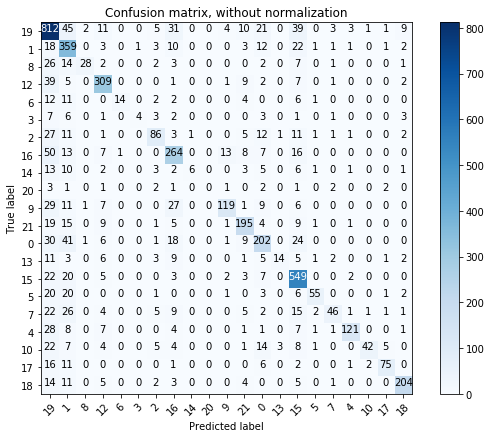

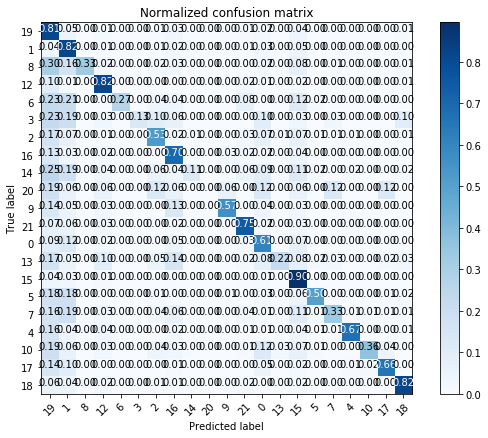

WITH 60.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.65      0.80      0.72       793
          1       0.53      0.84      0.65       414
         10       0.88      0.35      0.50        80
         12       0.79      0.80      0.80       342
         13       0.95      0.29      0.44        66
         14       0.90      0.19      0.32        47
         15       0.66      0.53      0.59       156
         16       0.66      0.69      0.68       377
         17       0.80      0.16      0.26        51
         18       0.00      0.00      0.00        21
         19       0.76      0.59      0.67       213
          2       0.82      0.78      0.80       288
         20       0.70      0.67      0.69       352
         21       0.65      0.18      0.28        72
          3       0.76      0.90      0.82       593
          4       0.80      0.51      0.62       131
          5       0.69      0.35      0.47       128
          6       0.87      0.71      0.78   

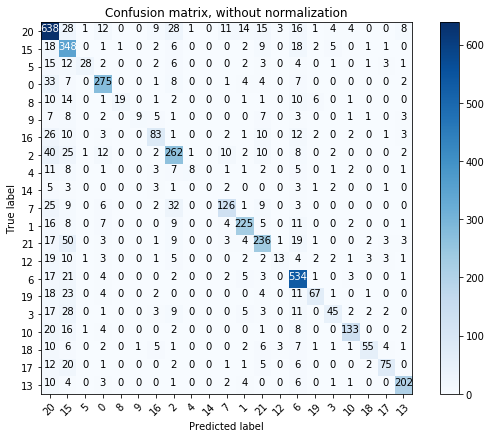

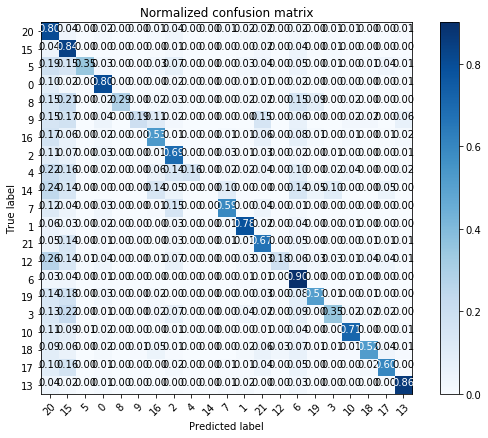

WITH 70.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.58      0.72      0.65       592
          1       0.55      0.86      0.67       416
         10       0.80      0.27      0.40        74
         12       0.76      0.82      0.79       352
         13       0.95      0.29      0.44        63
         14       1.00      0.22      0.36        41
         15       0.68      0.55      0.61       163
         16       0.63      0.67      0.65       394
         17       0.70      0.14      0.23        50
         18       0.00      0.00      0.00        15
         19       0.80      0.64      0.71       211
          2       0.81      0.73      0.77       291
         20       0.70      0.67      0.69       338
         21       0.62      0.15      0.24        55
          3       0.72      0.91      0.80       608
          4       0.84      0.49      0.62       109
          5       0.57      0.26      0.36       130
          6       0.89      0.73      0.80   

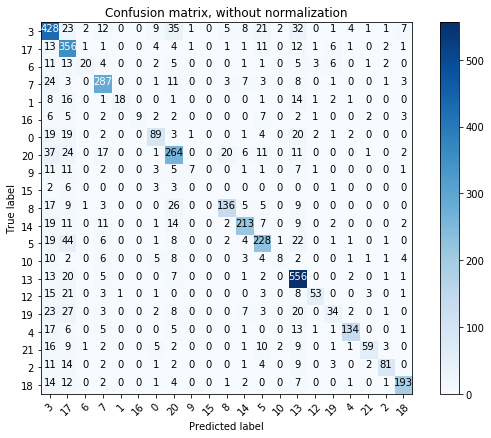

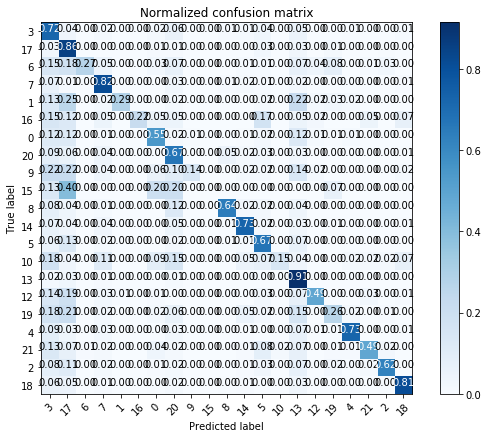

WITH 80.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.59      0.61      0.60       431
          1       0.56      0.86      0.68       420
         10       0.88      0.31      0.46        94
         12       0.78      0.82      0.80       375
         13       0.95      0.33      0.49        61
         14       0.88      0.22      0.35        32
         15       0.67      0.54      0.60       166
         16       0.66      0.76      0.71       382
         17       1.00      0.17      0.30        52
         18       1.00      0.06      0.11        18
         19       0.78      0.64      0.70       200
          2       0.78      0.78      0.78       244
         20       0.65      0.64      0.65       320
         21       0.74      0.35      0.48        74
          3       0.70      0.92      0.80       583
          4       0.80      0.58      0.67       105
          5       0.69      0.38      0.49       122
          6       0.88 

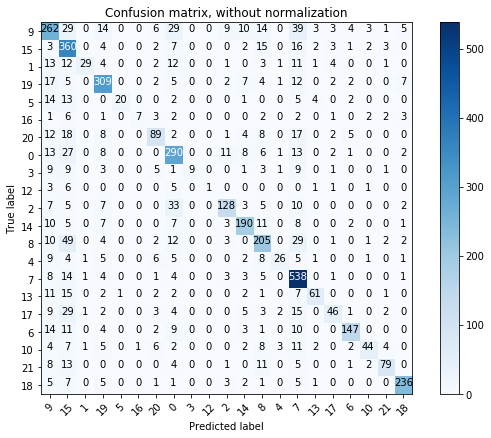

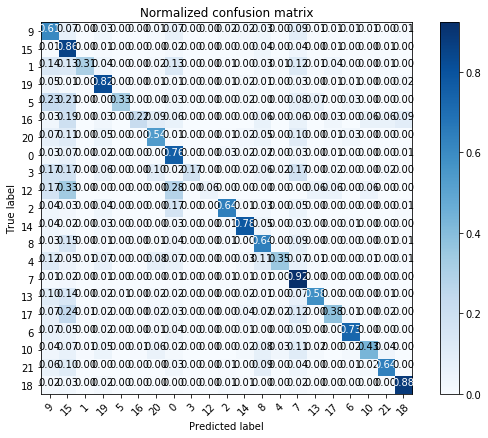

WITH 90.0% 0S REMOVED


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.55      0.42      0.48       186
          1       0.56      0.88      0.68       456
         10       0.80      0.29      0.43        96
         12       0.81      0.84      0.83       365
         13       0.88      0.19      0.31        74
         14       1.00      0.50      0.67        20
         15       0.63      0.65      0.64       160
         16       0.65      0.80      0.72       359
         17       1.00      0.19      0.31        54
         18       0.00      0.00      0.00        11
         19       0.82      0.67      0.74       215
          2       0.78      0.80      0.79       246
         20       0.70      0.68      0.69       343
         21       0.69      0.29      0.41        68
          3       0.75      0.92      0.82       598
          4       0.82      0.51      0.63       127
          5       0.68      0.43      0.53       120
          6       0.83      0.79      0.81   

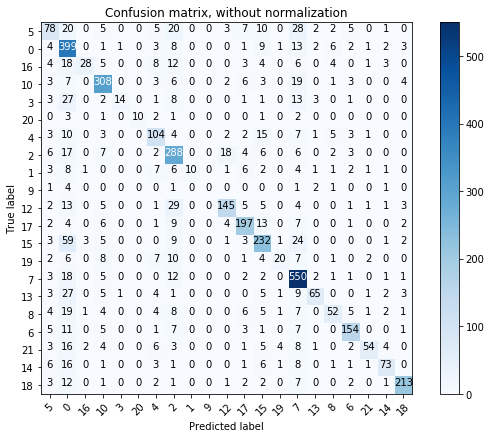

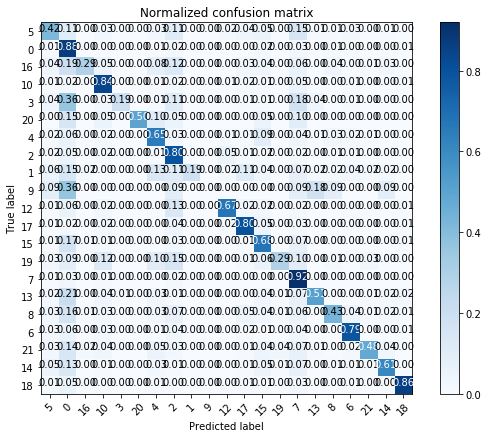

CPU times: user 2min 46s, sys: 8.71 s, total: 2min 54s
Wall time: 2min 39s


In [54]:
%%time
nb = MultinomialNB()

pipeline = make_pipeline(vec,
                        nb)

for k,v in train_test.items():
    print("WITH " + str(k*100) + "% 0S REMOVED")
    pipeline.fit(v[0], v[2])
#     joblib.dump(pipeline, '../../../../models/best/nb/nb_' + str(k) + '.pkl')
    eval_classifier(pipeline, v[1], v[3])

## Logistic Regression Classifier

WITH 10.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.74      0.89      0.81      1812
          1       0.78      0.75      0.76       445
         10       0.84      0.61      0.71        79
         12       0.87      0.79      0.83       370
         13       0.81      0.58      0.67        50
         14       0.84      0.47      0.60        34
         15       0.72      0.60      0.65       196
         16       0.71      0.71      0.71       357
         17       0.44      0.44      0.44        36
         18       0.50      0.24      0.32        17
         19       0.77      0.65      0.71       225
          2       0.83      0.74      0.78       276
         20       0.75      0.66      0.70       344
         21       0.59      0.44      0.50        73
          3       0.88      0.87      0.88       559
          4       0.78      0.76      0.77       120
          5       0.65      0.54      0.59       130
          6       0.86 

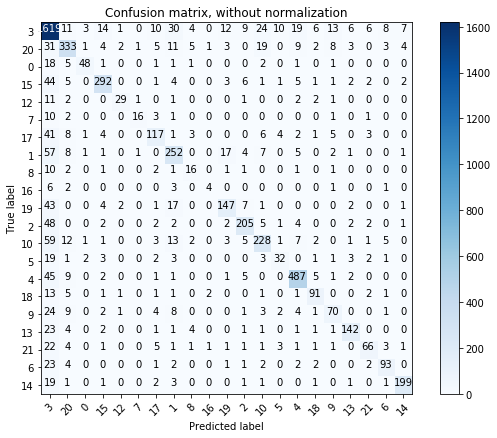

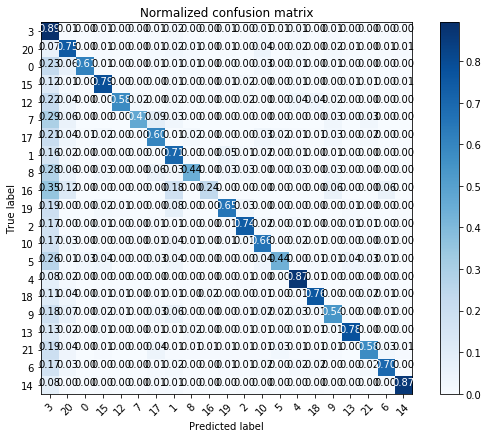

WITH 20.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.71      0.87      0.78      1567
          1       0.78      0.80      0.79       417
         10       0.82      0.64      0.72        87
         12       0.88      0.79      0.83       381
         13       0.79      0.58      0.67        66
         14       0.74      0.69      0.71        29
         15       0.69      0.65      0.67       178
         16       0.74      0.66      0.70       396
         17       0.67      0.60      0.63        47
         18       0.50      0.14      0.22        14
         19       0.75      0.65      0.70       216
          2       0.84      0.80      0.82       270
         20       0.75      0.70      0.73       339
         21       0.71      0.44      0.54        73
          3       0.90      0.88      0.89       628
          4       0.81      0.73      0.77       108
          5       0.64      0.49      0.56       116
          6       0.90 

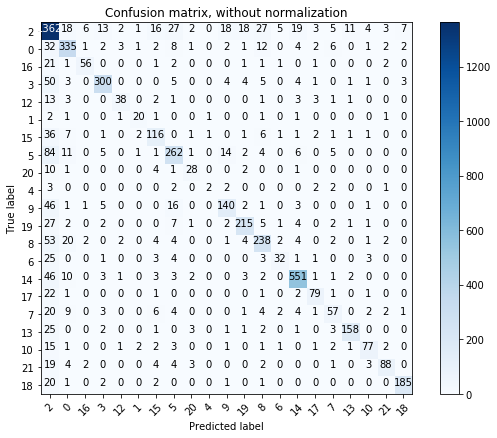

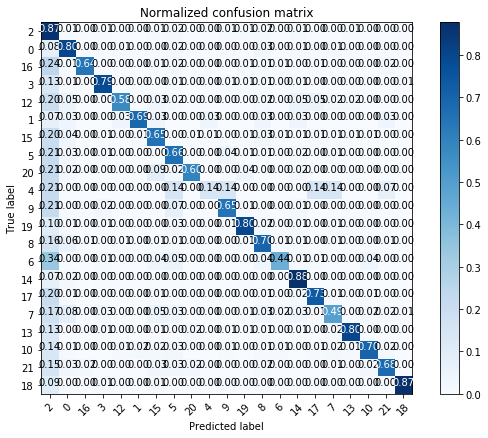

WITH 30.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.72      0.88      0.79      1475
          1       0.80      0.79      0.79       405
         10       0.83      0.57      0.68        84
         12       0.88      0.83      0.85       329
         13       0.85      0.67      0.75        70
         14       0.93      0.60      0.72        42
         15       0.73      0.68      0.70       156
         16       0.70      0.69      0.69       375
         17       0.65      0.38      0.48        52
         18       0.33      0.18      0.23        17
         19       0.81      0.69      0.75       213
          2       0.89      0.75      0.81       253
         20       0.72      0.73      0.73       318
         21       0.65      0.47      0.54        86
          3       0.91      0.89      0.90       602
          4       0.85      0.74      0.79       108
          5       0.56      0.47      0.51       120
          6       0.86 

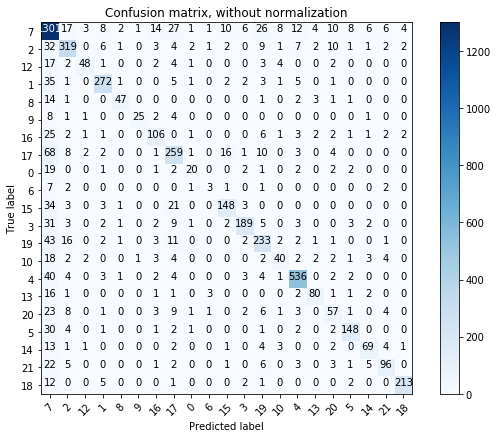

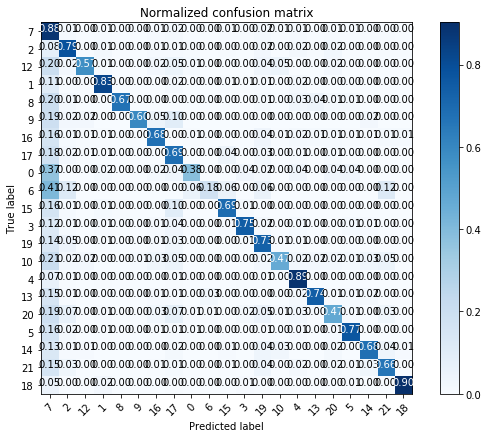

WITH 40.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.70      0.87      0.77      1183
          1       0.78      0.78      0.78       428
         10       0.71      0.50      0.59        74
         12       0.87      0.85      0.86       377
         13       0.83      0.62      0.71        63
         14       0.79      0.74      0.76        35
         15       0.73      0.69      0.71       191
         16       0.73      0.71      0.72       372
         17       0.79      0.66      0.72        50
         18       0.57      0.33      0.42        12
         19       0.77      0.67      0.72       224
          2       0.84      0.76      0.80       258
         20       0.75      0.71      0.73       342
         21       0.68      0.43      0.53        69
          3       0.89      0.86      0.88       615
          4       0.84      0.68      0.75       108
          5       0.69      0.52      0.59       130
          6       0.85 

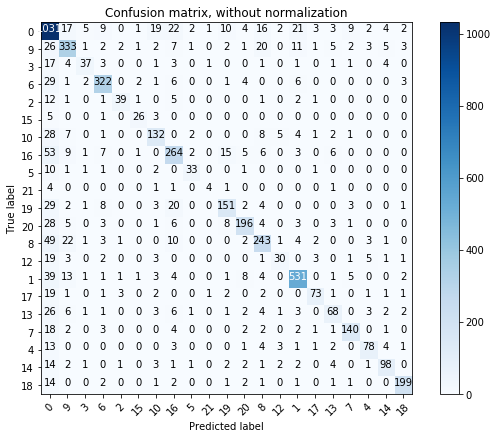

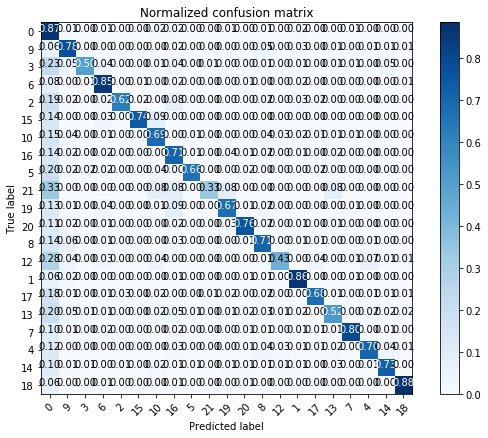

WITH 50.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.67      0.84      0.75       997
          1       0.76      0.76      0.76       437
         10       0.77      0.64      0.70        86
         12       0.86      0.80      0.83       376
         13       0.84      0.60      0.70        52
         14       0.85      0.71      0.77        31
         15       0.73      0.61      0.66       163
         16       0.73      0.71      0.72       379
         17       0.70      0.43      0.53        53
         18       0.50      0.31      0.38        16
         19       0.85      0.74      0.79       210
          2       0.79      0.81      0.80       260
         20       0.74      0.69      0.71       333
         21       0.66      0.52      0.58        63
          3       0.89      0.92      0.91       613
          4       0.82      0.81      0.81       109
          5       0.67      0.54      0.60       140
          6       0.88 

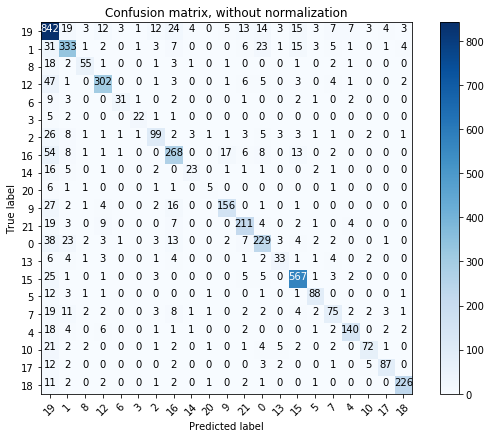

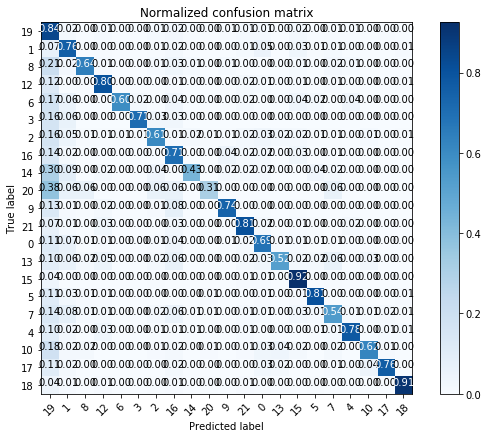

WITH 60.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.66      0.80      0.73       793
          1       0.72      0.81      0.77       414
         10       0.77      0.62      0.69        80
         12       0.86      0.82      0.84       342
         13       0.82      0.55      0.65        66
         14       0.90      0.77      0.83        47
         15       0.67      0.67      0.67       156
         16       0.72      0.70      0.71       377
         17       0.61      0.45      0.52        51
         18       0.50      0.19      0.28        21
         19       0.80      0.74      0.77       213
          2       0.83      0.77      0.80       288
         20       0.75      0.70      0.73       352
         21       0.69      0.56      0.62        72
          3       0.91      0.90      0.91       593
          4       0.82      0.77      0.80       131
          5       0.61      0.49      0.54       128
          6       0.88 

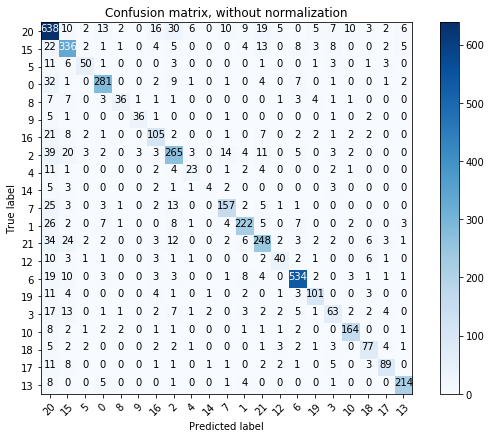

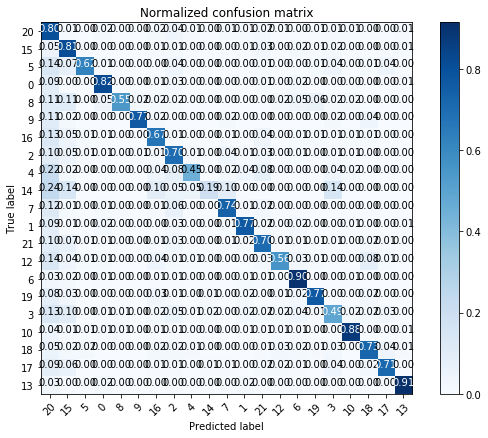

WITH 70.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.63      0.80      0.70       592
          1       0.79      0.84      0.81       416
         10       0.73      0.62      0.67        74
         12       0.87      0.82      0.84       352
         13       0.77      0.68      0.72        63
         14       0.81      0.61      0.69        41
         15       0.73      0.65      0.69       163
         16       0.72      0.72      0.72       394
         17       0.79      0.52      0.63        50
         18       0.67      0.27      0.38        15
         19       0.75      0.73      0.74       211
          2       0.87      0.80      0.83       291
         20       0.79      0.74      0.77       338
         21       0.60      0.58      0.59        55
          3       0.87      0.91      0.89       608
          4       0.86      0.76      0.81       109
          5       0.61      0.56      0.58       130
          6       0.87 

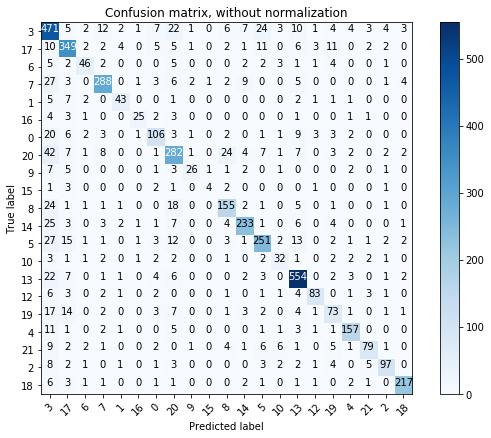

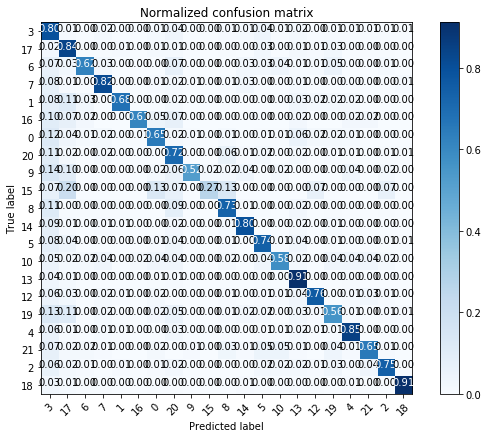

WITH 80.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.59      0.73      0.65       431
          1       0.76      0.84      0.80       420
         10       0.80      0.60      0.68        94
         12       0.86      0.83      0.85       375
         13       0.77      0.61      0.68        61
         14       0.83      0.59      0.69        32
         15       0.72      0.65      0.68       166
         16       0.75      0.79      0.77       382
         17       0.91      0.58      0.71        52
         18       0.70      0.39      0.50        18
         19       0.78      0.77      0.78       200
          2       0.82      0.77      0.80       244
         20       0.71      0.74      0.73       320
         21       0.60      0.68      0.63        74
          3       0.90      0.91      0.90       583
          4       0.81      0.76      0.78       105
          5       0.71      0.63      0.67       122
          6       0.88 

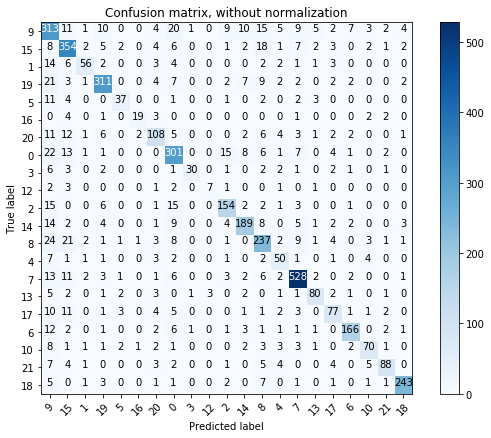

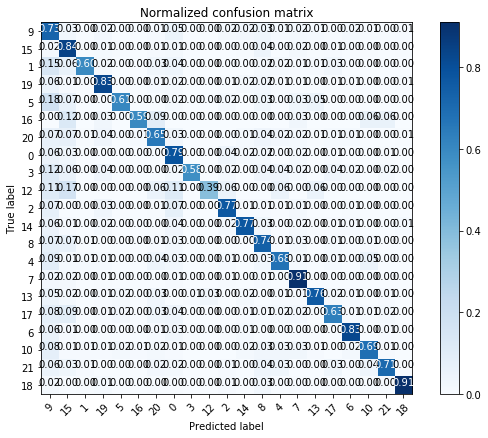

WITH 90.0% 0S REMOVED
             precision    recall  f1-score   support

          0       0.47      0.63      0.54       186
          1       0.77      0.84      0.80       456
         10       0.75      0.58      0.65        96
         12       0.87      0.86      0.87       365
         13       0.80      0.66      0.73        74
         14       0.68      0.75      0.71        20
         15       0.71      0.76      0.74       160
         16       0.73      0.78      0.76       359
         17       0.91      0.57      0.70        54
         18       0.67      0.18      0.29        11
         19       0.81      0.75      0.78       215
          2       0.84      0.87      0.85       246
         20       0.74      0.76      0.75       343
         21       0.74      0.57      0.64        68
          3       0.90      0.91      0.91       598
          4       0.89      0.73      0.81       127
          5       0.64      0.59      0.61       120
          6       0.88 

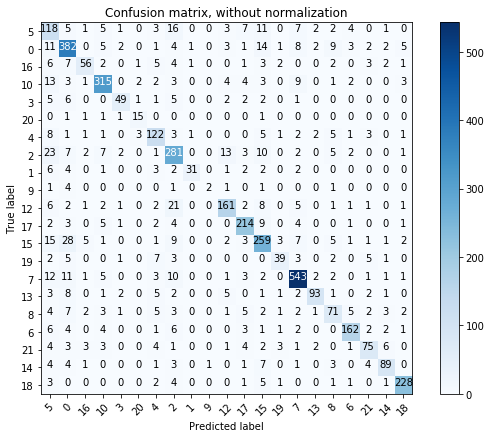

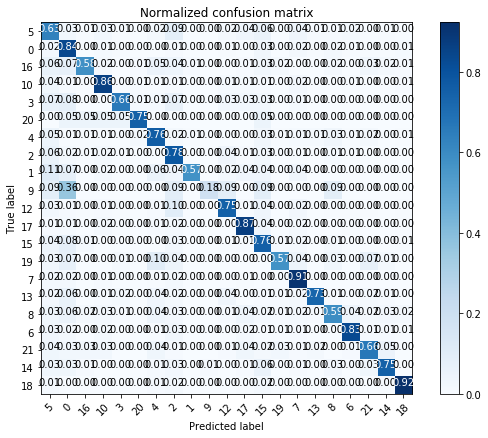

CPU times: user 1h 45min 44s, sys: 19min 56s, total: 2h 5min 40s
Wall time: 33min 49s


In [52]:
%%time
lr = LogisticRegressionCV(multi_class='ovr')

pipeline = make_pipeline(vec,
                        lr)

# v[0] = x_train, v[2] = y_train, v[1] = x_test, v[3] = y_test
for k,v in train_test.items():
    print("WITH " + str(k*100) + "% 0S REMOVED")
    pipeline.fit(v[0], v[2])
#     joblib.dump(pipeline, '../../../../models/best/lr/lr_' + str(k) + '.pkl')
    eval_classifier(pipeline, v[1], v[3])

WITH 90.0% 0S REMOVED


/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/angelaschopke/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

              precision    recall  f1-score   support

           0       0.53      0.66      0.59       186
           1       0.79      0.84      0.82       476
          10       0.80      0.68      0.74        76
          12       0.84      0.86      0.85       354
          13       0.90      0.70      0.79        66
          14       0.92      0.88      0.90        25
          15       0.78      0.77      0.77       177
          16       0.70      0.78      0.74       353
          17       0.68      0.49      0.57        57
          18       0.90      0.39      0.55        23
          19       0.81      0.74      0.77       206
           2       0.85      0.81      0.83       257
          20       0.75      0.77      0.76       358
          21       0.84      0.68      0.75        80
           3       0.91      0.93      0.92       602
           4       0.81      0.80      0.81        99
           5       0.71      0.70      0.71       140
           6       0.86    

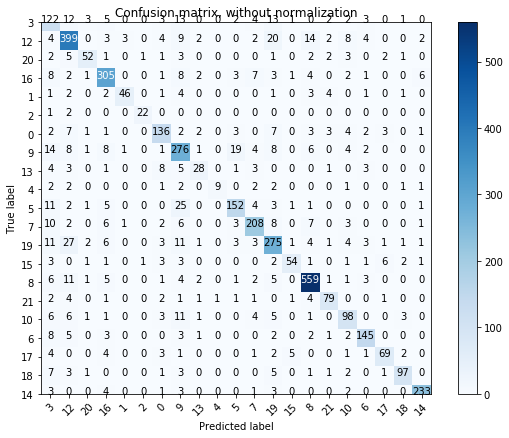

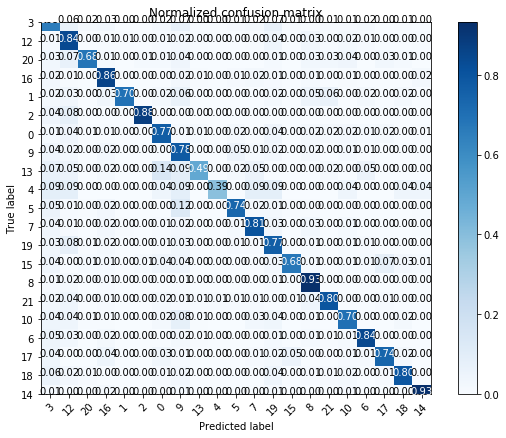

CPU times: user 20min 30s, sys: 2min 55s, total: 23min 25s
Wall time: 6min 9s


In [20]:
%%time
lr = LogisticRegressionCV(multi_class='ovr')

pipeline = make_pipeline(vec,
                        lr)

## reminder: v[0] = x_train, v[2] = y_train, v[1] = x_test, v[3] = y_test
for k,v in train_test.items():
    if k == 0.9:
        print("WITH " + str(k*100) + "% 0S REMOVED")
        pipeline.fit(v[0], v[2])
        ## uncomment to save model
        # joblib.dump(pipeline, '../../../../models/best/lr/lr_' + str(k) + '.pkl')
        eval_classifier(pipeline, v[1], v[3])
    else:
        continue